<a href="https://colab.research.google.com/github/MarcioVSousa/ProjetoRegressaoLinear/blob/main/Projeto_Regress%C3%A3o_Linear_T3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook por Márcio Vinícius Moura de Sousa e Vinícius Neves de Almeida
### Trilha Ciência de Dados - Projeto da Unidade 9: Regressão Linear

# Projeto: Implementação e Ánalise do Algoritmo de Regressão Linear
## Objetivos:
O objetivo deste projeto é desenvolver um modelo preditivo usando o algoritmo de
Regressão Linear para resolver um problema de inferência sobre taxa de engajamento dos
principais influenciadores do instagram. O projeto envolve desde a análise exploratória dos
dados até a otimização e validação do modelo. A base de dados apresenta as seguintes variáveis para cada componente:

*   **rank:** Um ranking dos influencers baseado no número de seguidores.

*   **influence score:** Taxa de influência dos usuários. É calculado baseado em menções, importância e popularidade.

*   **channel_info:** Nome de usuário do influencer.

*   **posts:** Número total de posts feitos pelo influencer.

*  **followers:** Número de seguidores do influencer.

*   **avg_likes:** Média de likes dos posts do influencer (total de likes/ total de posts).

*   **new_post_avg_like:** Média de likes dos posts novos do influencer.

*   **total Likes:** Total de likes que os influencers têm em todos os seus posts (em bilhões).

*   **country:** País ou região do usuário.

*   **60_day_eng_rate:** Taxa de engajamento do influencer nos últimos 60 dias como fração de engajamentos que eles realizaram até agora.


# Importação das Bibliotecas Necessárias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
def converterUnidade(value): # Como boa parte dos valores das colunas são strings, preciso converter para numérico para uma melhor manipulação dos dados.
    if isinstance(value, str): # Se for uma string

        if 'b' in value:
            return float(value.replace('b', '')) * 1_000_000_000

        elif 'm' in value:
            return float(value.replace('m', '')) * 1_000_000

        elif 'k' in value:
            return float(value.replace('k', '')) * 1_000

        else:
            return float(value.replace('%', ''))

    return value # Se já for numeric

sns.set(style= 'whitegrid')

url = 'https://drive.google.com/uc?export=download&id=1PEVjCKqK2MlTxBno0d32qpK5AldMrJ_X'
influencers_df = pd.read_csv(url)

influencers_df.head()

,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country
0,1,cristiano,92,3.3k,475.8m,8.7m,1.39%,6.5m,29.0b,Spain
1,2,kyliejenner,91,6.9k,366.2m,8.3m,1.62%,5.9m,57.4b,United States
2,3,leomessi,90,0.89k,357.3m,6.8m,1.24%,4.4m,6.0b,NaN
3,4,selenagomez,93,1.8k,342.7m,6.2m,0.97%,3.3m,11.5b,United States
4,5,therock,91,6.8k,334.1m,1.9m,0.20%,665.3k,12.5b,United States


# Análise Exploratória dos Dados

In [ ]:
influencers_df_clean = influencers_df.drop(columns=['channel_info', 'country'])
influencers_df_clean.head()

,rank,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes
0,1,92,3.3k,475.8m,8.7m,1.39%,6.5m,29.0b
1,2,91,6.9k,366.2m,8.3m,1.62%,5.9m,57.4b
2,3,90,0.89k,357.3m,6.8m,1.24%,4.4m,6.0b
3,4,93,1.8k,342.7m,6.2m,0.97%,3.3m,11.5b
4,5,91,6.8k,334.1m,1.9m,0.20%,665.3k,12.5b


 Foi retirada a coluna "country", pois 31% das linhas do dataset possuem valores nulos nessa coluna, o que acarretaria num dataframe com pouco valor. Já "channel_info" não foi considerada uma variável relevante para a análise.

In [ ]:
influencers_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rank               200 non-null    int64 
 1   influence_score    200 non-null    int64 
 2   posts              200 non-null    object
 3   followers          200 non-null    object
 4   avg_likes          200 non-null    object
 5   60_day_eng_rate    200 non-null    object
 6   new_post_avg_like  200 non-null    object
 7   total_likes        200 non-null    object
dtypes: int64(2), object(6)
memory usage: 12.6+ KB


In [ ]:
for column in influencers_df_clean: # Convertendo as variáveis non-numeric para numeric
    influencers_df_clean[column] = influencers_df_clean[column].apply(converterUnidade)
influencers_df_clean = influencers_df_clean.dropna()
influencers_df_clean.shape

(199, 8)

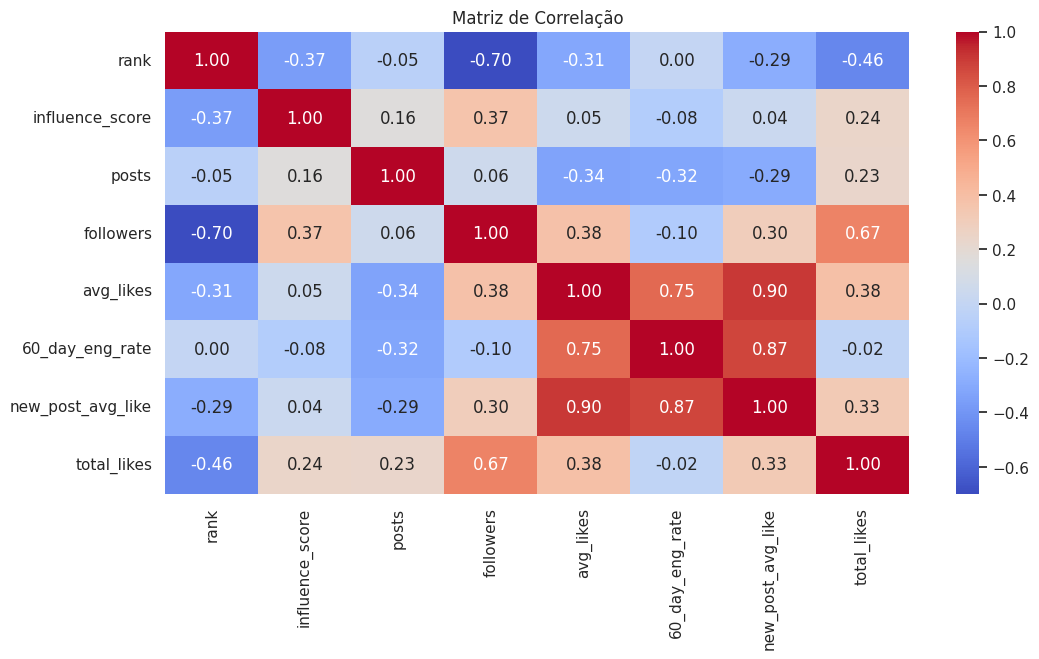

In [ ]:
# MATRIZ DE CORRELAÇÃO

corr = influencers_df_clean.corr(numeric_only=True)
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

In [ ]:
# ANALISANDO A MULTICOLINEARIDADE USANDO VIF (Variance Inflation Factor)

features = influencers_df_clean.drop(columns=['60_day_eng_rate'], axis=1) # Separando as features do target para análise

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features) # Padronização dos dados

vif = pd.DataFrame()
vif['Feature'] = features.columns
vif['VIF'] = [variance_inflation_factor(features_scaled, i) for i in range(features_scaled.shape[1])]
print("Variance Inflation Factor:")
print(vif)

Variance Inflation Factor:
             Feature       VIF
0               rank  2.046737
1    influence_score  1.221645
2              posts  1.398103
3          followers  2.938283
4          avg_likes  6.171564
5  new_post_avg_like  5.418111
6        total_likes  2.174375


'new_post_avg_like' e 'avg_likes' apresentando uma forte multicolinearidade.

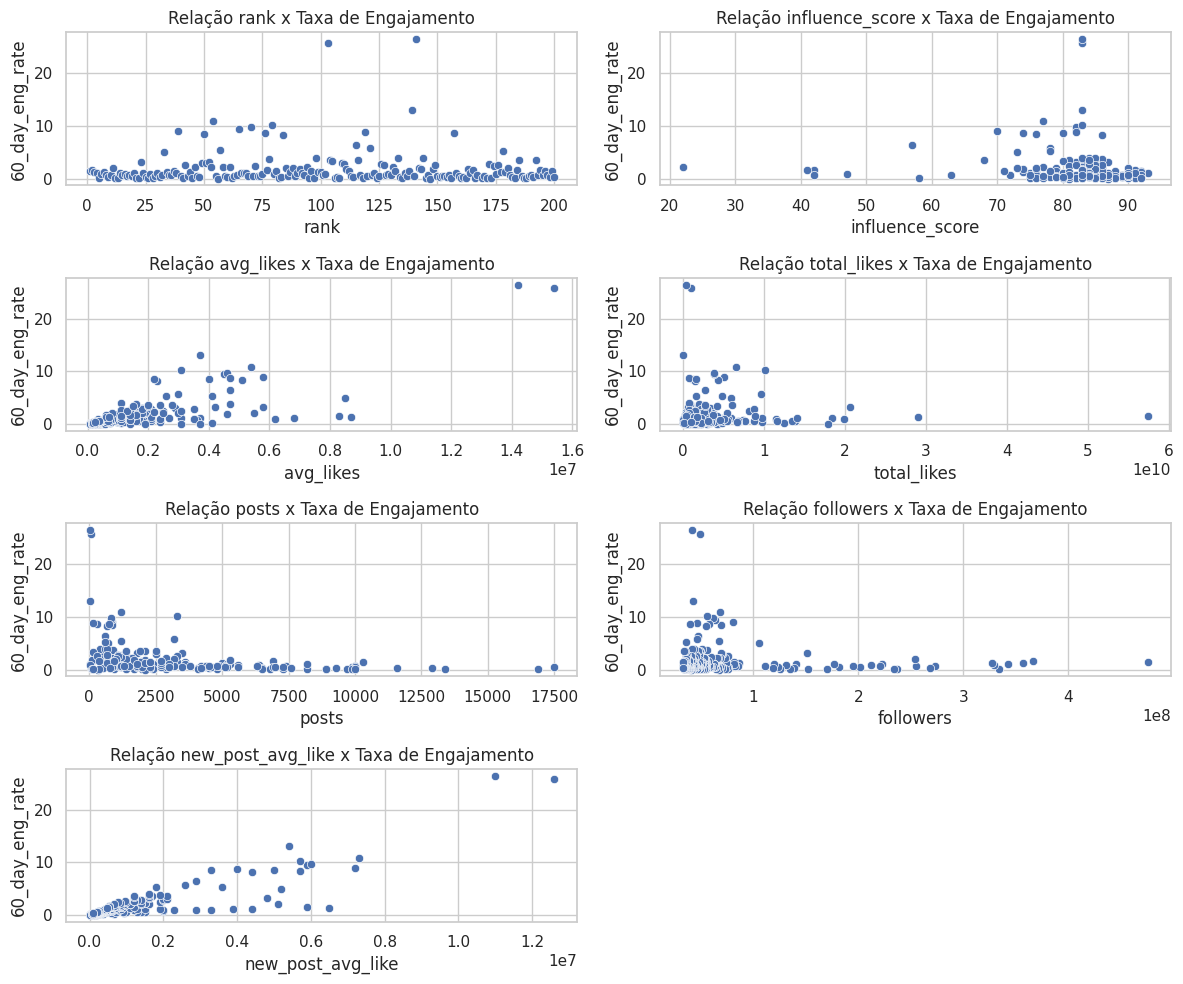

In [ ]:
# PLOTANDO AS RELAÇÕES DAS COLUNAS X's COM A COLUNA Y ('60_day_eng_rate')

plt.figure(figsize=(12, 10)) # As dimensões das figuras dos gráficos

relevant_columns = ['rank', 'influence_score', 'avg_likes', 'total_likes' ,'posts', 'followers', 'new_post_avg_like']
target = '60_day_eng_rate'

for i, column in enumerate(relevant_columns, 1): # Para construir o layout dos gráficos de dispersão
    plt.subplot(4, 2, i) #Define o grid dos gráficos
    sns.scatterplot(data=influencers_df_clean, x = column, y = '60_day_eng_rate')
    plt.title(f'Relação {column} x Taxa de Engajamento')
    plt.xlabel(column)
    plt.ylabel('60_day_eng_rate')


plt.tight_layout() # Para que os gráficos não se sobreponham
plt.show()

In [ ]:
# DROPANDO COLUNAS QUE APRESENTAM ALTA CORRELAÇÃO ENTRE SI E POUCA RELAÇÃO COM O TARGET

influencers_df_clean.drop(columns=['rank', 'avg_likes', 'total_likes'], inplace=True)
influencers_df_clean.head()

,influence_score,posts,followers,60_day_eng_rate,new_post_avg_like
0,92,3300.0,475800000.0,1.39,6500000.0
1,91,6900.0,366200000.0,1.62,5900000.0
2,90,890.0,357300000.0,1.24,4400000.0
3,93,1800.0,342700000.0,0.97,3300000.0
4,91,6800.0,334100000.0,0.20,665300.0


# Divisão de Dados e Treinamento

In [ ]:
xInfluencers = influencers_df_clean.drop('60_day_eng_rate', axis=1)
yInfluencers = influencers_df_clean['60_day_eng_rate']

xInfluencers_scaled = scaler.fit_transform(xInfluencers) # Normalizando os dados para melhor controle e performance

xTrain, xTest, yTrain, yTest = train_test_split(xInfluencers_scaled, yInfluencers, test_size=0.2, random_state=42) # 80% para treinamento e 20% para teste

model = LinearRegression()
model.fit(xTrain, yTrain)

LinearRegression()

# Avaliação do Modelo Linear

In [ ]:
yPrevisto = model.predict(xTest)
MSE_Influencers = mean_squared_error(yTest, yPrevisto) ** 0.5 # RMSE DA TAXA DE ERRO
r2_Influencers = r2_score(yTest, yPrevisto) # R² do modelo

print(f'RMSE: {MSE_Influencers:.2f}')
print(f'R²: {r2_Influencers:.2f}')

RMSE: 0.56
R²: 0.95


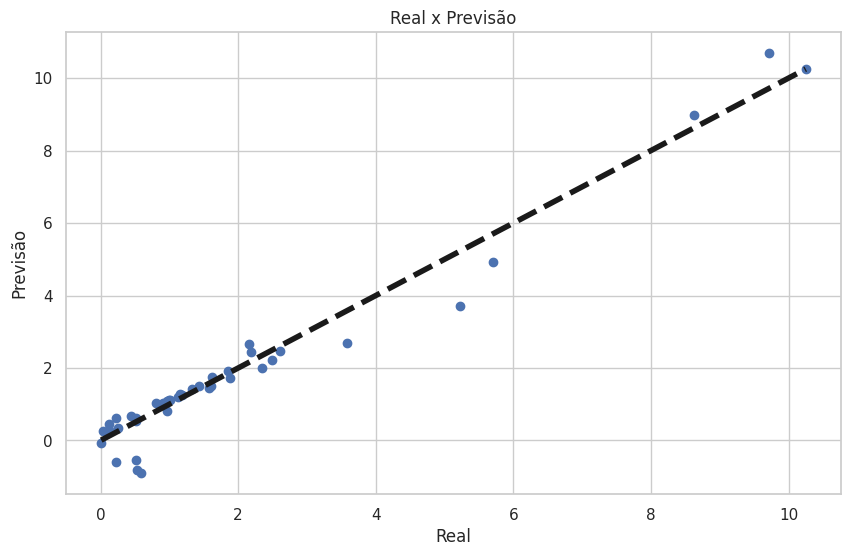

In [ ]:
# VISUALIZANDO OS RESULTADOS

plt.figure(figsize=(10,6))
plt.scatter(yTest, yPrevisto)
plt.plot([yTest.min(), yTest.max()], [yTest.min(), yTest.max()], 'k--', lw=4)
plt.xlabel('Real')
plt.ylabel('Previsão')
plt.title('Real x Previsão')
plt.show()

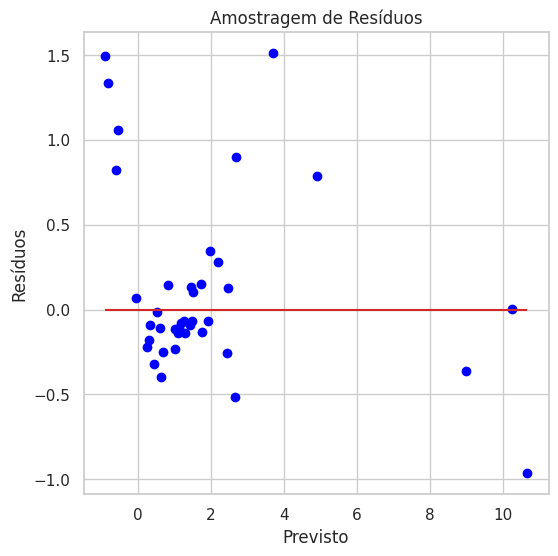

In [ ]:
# ANALISANDO OS RESÍDUOS

residuos = yTest - yPrevisto
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(yPrevisto, residuos, color='blue')
ax.hlines(0, xmin = yPrevisto.min(), xmax = yPrevisto.max(), color='tab:red')
plt.xlabel('Previsto')
plt.ylabel('Resíduos')
plt.title('Amostragem de Resíduos')
plt.grid(True)
plt.show()

# Ajuste do Modelo e Regularização com Ridge e Lasso

In [ ]:
# TREINANDO OS MODELOS

ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1)

ridge_model.fit(xTrain, yTrain)
lasso_model.fit(xTrain, yTrain)

Lasso(alpha=0.1)

## Avaliando os Modelos

In [ ]:
# Previsão com Ridge e Lasso
yPrevisto_ridge = ridge_model.predict(xTest)
yPrevisto_lasso = lasso_model.predict(xTest)

# Avaliação dos Modelos Ridge e Lasso
print(f'Ridge RMSE: {mean_squared_error(yTest, yPrevisto_ridge) ** 0.5:.2f}')
print(f'Ridge R²: {r2_score(yTest, yPrevisto_ridge):.2f}')
print(f'\nLasso RMSE: {mean_squared_error(yTest, yPrevisto_lasso) ** 0.5:.2f}')
print(f'Lasso R²: {r2_score(yTest, yPrevisto_lasso):.2f}')

Ridge RMSE: 0.55
Ridge R²: 0.95

Lasso RMSE: 0.51
Lasso R²: 0.96


Os modelos regularizados apresentam melhores resultados em relação ao modelo lienar não-regularizado. No entanto, o modelo Lasso apresenta melhores métricas.

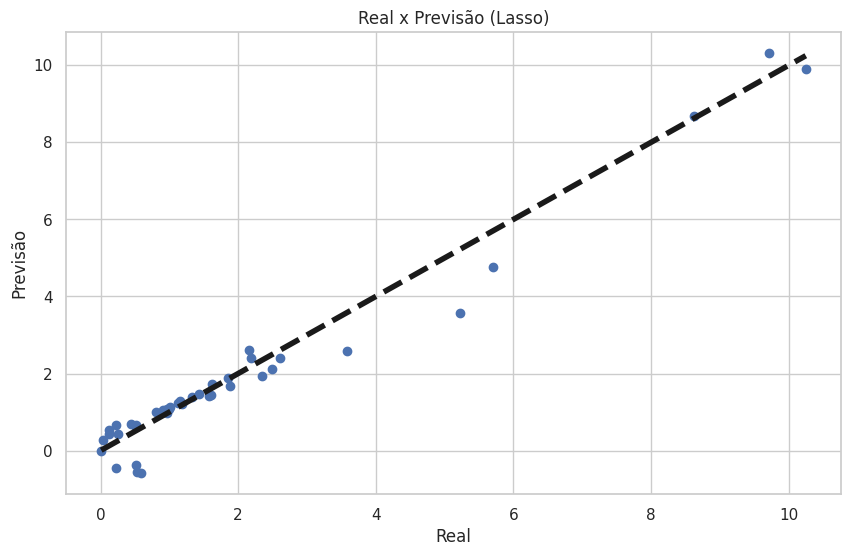

In [ ]:
# VISUALIZANDO OS RESULTADOS

plt.figure(figsize=(10,6))
plt.scatter(yTest, yPrevisto_lasso)
plt.plot([yTest.min(), yTest.max()], [yTest.min(), yTest.max()], 'k--', lw=4)
plt.xlabel('Real')
plt.ylabel('Previsão')
plt.title('Real x Previsão (Lasso)')
plt.show()

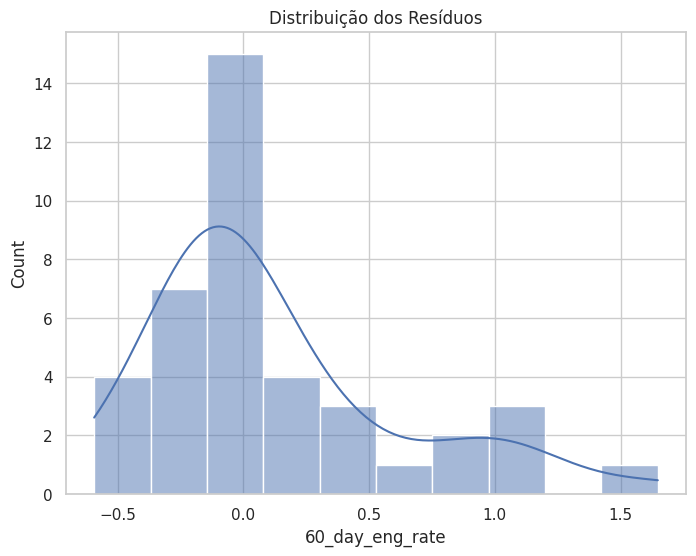

In [ ]:
# DISTRIBUIÇÃO DOS RESÍDUOS

residuos = yTest - yPrevisto_lasso
plt.figure(figsize=(8, 6))
sns.histplot(residuos, kde=True)
plt.title('Distribuição dos Resíduos')
plt.show()